# Benchmark: PXD038699

Spatial single-cell mass spectrometry dataset available at [PRIDE](https://www.ebi.ac.uk/pride/archive/projects/PXD038699).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import manns_lab_support as sup
from scp.models import PROTVI
import scp.plots as pl
import scp.utils

import scvi

np.random.seed(0)
scvi.settings.seed = 0

Global seed set to 0


## Data loading

Let's define the path to the data and load it into anndata.

In [2]:
DATA_DIR = "../data/PXD038699/"

ANNOTATIONS_PATH = os.path.join(DATA_DIR, "meta_5shape.tsv")
DATA_PATH = os.path.join(DATA_DIR, "proteintable_5shapes.tsv")

In [3]:
data = pd.read_csv(DATA_PATH, sep="\t")
annotations = pd.read_csv(ANNOTATIONS_PATH, sep="\t")

annotations.set_index("File", inplace=True)

var_cols = [c for c in data.columns if "I:\\" not in c]
vars = data[var_cols]

data.drop(var_cols, axis=1, inplace=True)

data = data.T
data = np.log(data + 1)

obs_names = [filename.split("\\")[-1][:-2] for filename in data.index.copy()]
data.index = obs_names

obs = pd.DataFrame(index=obs_names)
obs = obs.join(annotations, how="left")

adata = sc.AnnData(X=data, obs=obs, var=vars)

In [4]:
adata = adata[~np.all(np.isnan(adata.X), axis=1), :].copy()
adata = adata[:, ~np.all(np.isnan(adata.X), axis=0)].copy()

adata.layers["raw"] = adata.X.copy()

In [5]:
adata

AnnData object with n_obs × n_vars = 228 × 2492
    obs: 'sample', 'slide', 'frame', 'sample_batch', 'evobox', 'mouse'
    var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description'
    layers: 'raw'

In [6]:
adata.obs.head(5)

,sample,slide,frame,sample_batch,evobox,mouse
20220217_TIMS06_FAS_SA_SpatialDVP_visuallibmales_DIA_slide01_frame01_S2-A1_1_2022,slide01_frame01,1,1,1,1,5
20220217_TIMS06_FAS_SA_SpatialDVP_visuallibmales_DIA_slide01_frame02_S2-A2_1_2023,slide01_frame02,1,2,1,1,5
20220217_TIMS06_FAS_SA_SpatialDVP_visuallibmales_DIA_slide01_frame03_S2-A3_1_2024,slide01_frame03,1,3,1,1,5
20220217_TIMS06_FAS_SA_SpatialDVP_visuallibmales_DIA_slide01_frame04_S2-A4_1_2025,slide01_frame04,1,4,1,1,5
20220217_TIMS06_FAS_SA_SpatialDVP_visuallibmales_DIA_slide01_frame05_S2-A5_1_2026,slide01_frame05,1,5,1,1,5


In [7]:
adata.var.head(5)

,Protein.Group,Protein.Ids,Protein.Names,Genes,First.Protein.Description
0,A0A075B5N3,A0A075B5N3,A0A075B5N3_MOUSE,Igkv8-28,Immunoglobulin kappa variable 8-28
1,A0A075B6A3,A0A075B6A3,A0A075B6A3_MOUSE,Igha,Immunoglobulin heavy constant alpha (Fragment)
2,A0A087WNT1,A0A087WNT1,A0A087WNT1_MOUSE,Eloc,Elongin-C
3,A0A087WP14,A0A087WP14,A0A087WP14_MOUSE,Ktn1,Kinectin
4,A0A087WQF1,A0A087WQF1,A0A087WQF1_MOUSE,Clasp1,CLIP-associating protein 1


## Data Exploration

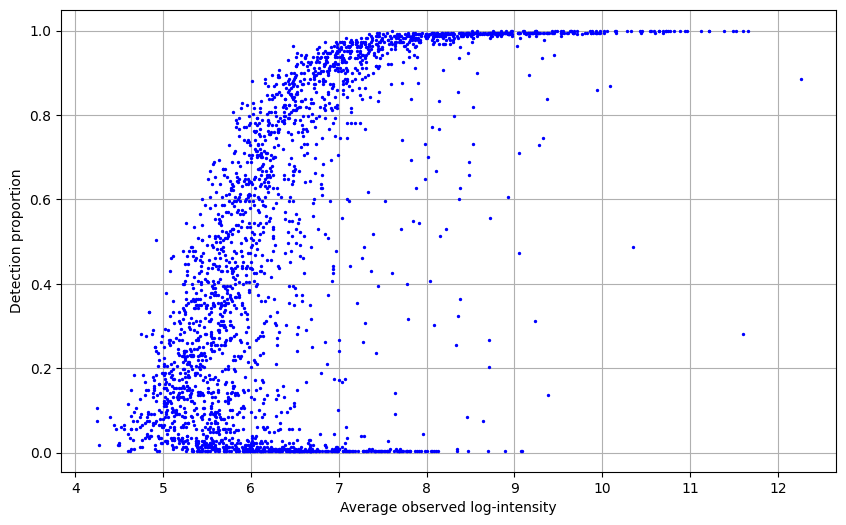

In [8]:
x = adata.layers["raw"]

avg_protein_intensities = np.nanmean(x, axis=0)
obs_detection_proportion = 1 - np.mean(np.isnan(x), axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(avg_protein_intensities, obs_detection_proportion, color="blue", s=2)
ax.set_xlabel("Average observed log-intensity")
ax.set_ylabel("Detection proportion")
ax.grid(True)
ax.set_axisbelow(True)

## PROTVI

### Training

Let's now train the model.

In [9]:
adata.X = adata.layers["raw"].copy()
adata.X[np.isnan(adata.X)] = 0

In [10]:
PROTVI.setup_anndata(adata, batch_key="sample_batch")

model = PROTVI(adata, log_variational=False, n_latent=16)
#model.view_anndata_setup()

Let's train the model.

In [11]:
model.train(max_epochs=1000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:19<00:00, 13.80it/s, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=1.96e+3]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:19<00:00, 12.58it/s, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=1.96e+3]


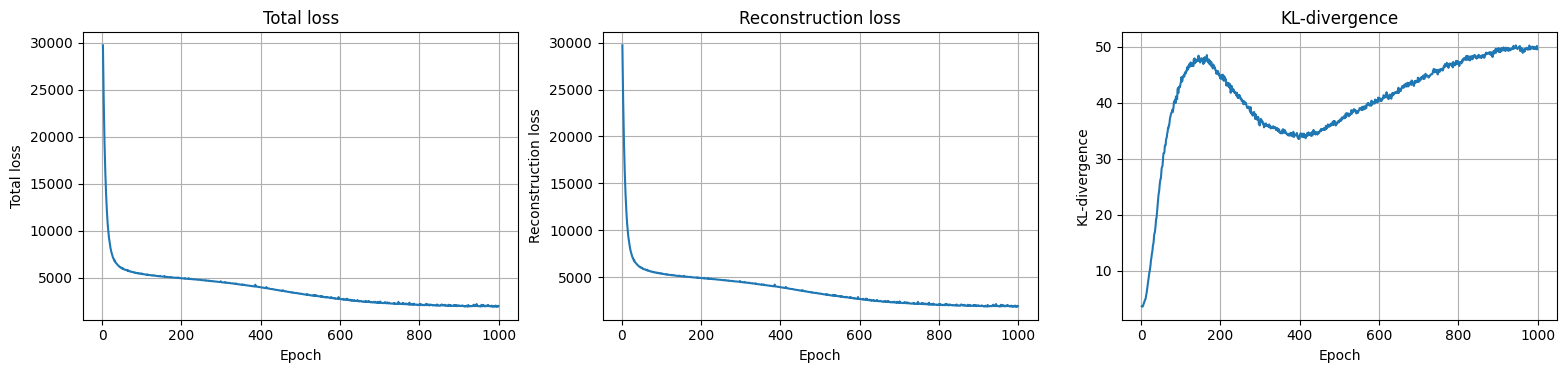

In [12]:
pl.plot_loss(model.history, n_skip=2)

### Evaluation on training set

In [13]:
x_est, p_est = model.impute()

x_data = adata.layers["raw"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

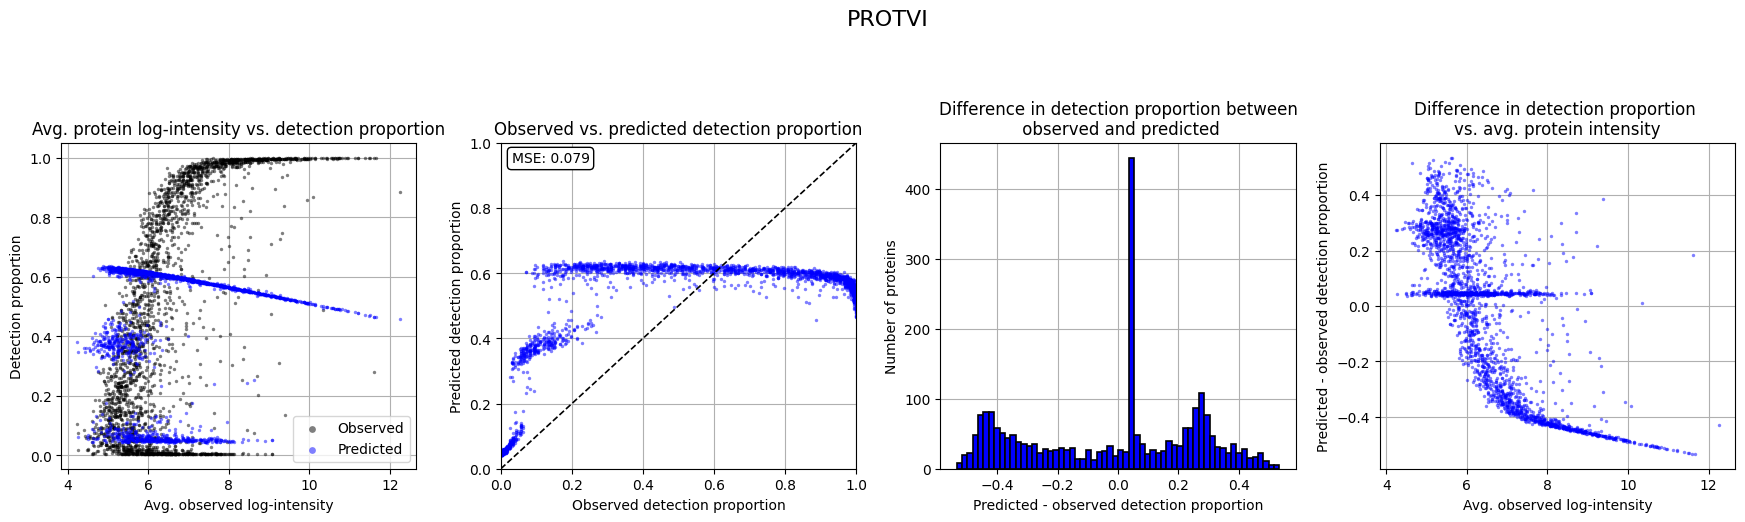

In [14]:
pl.plot_protein_detection_probability_panel(x_data, p_est)

Let's now compare the protein intensities predicted by the model and the intensities in dataset.

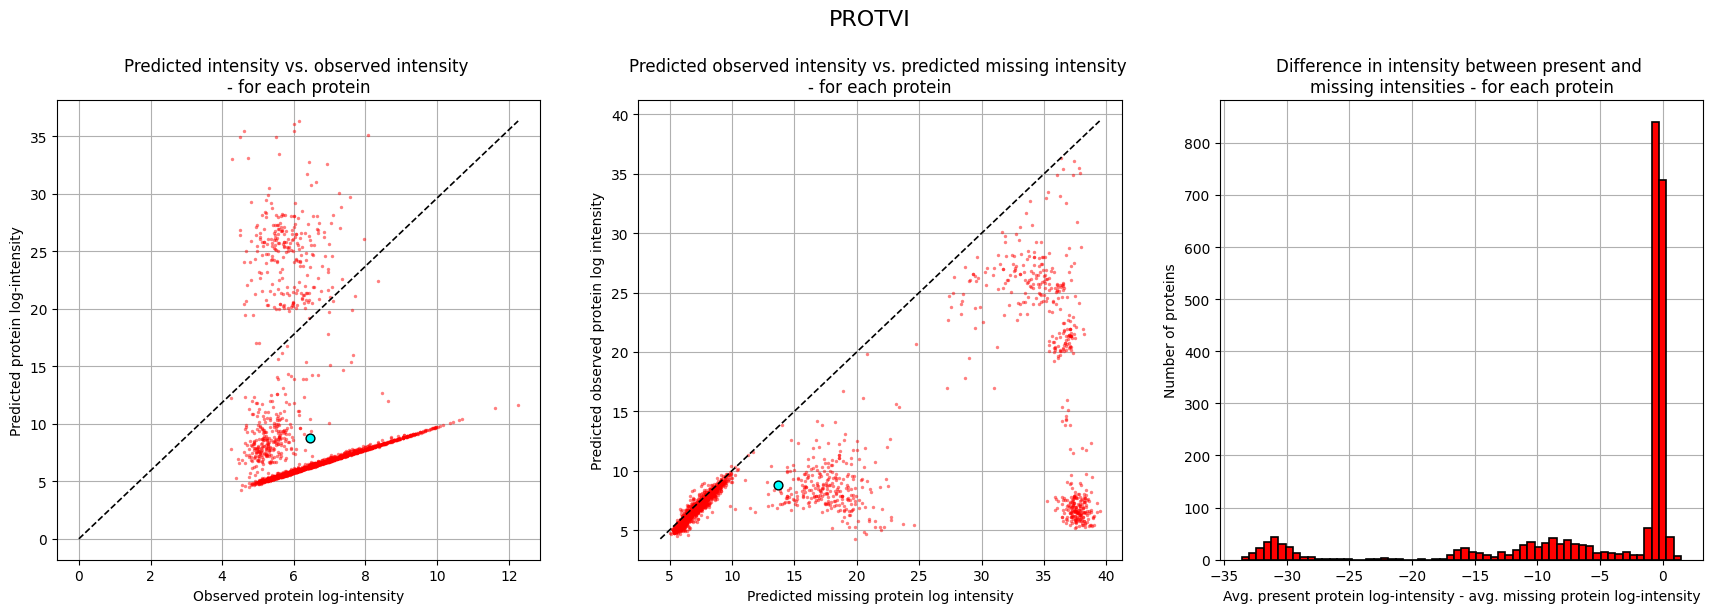

In [15]:
pl.plot_protein_intensity_panel(x_data, x_est)

Let's look at the latent space.

In [16]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

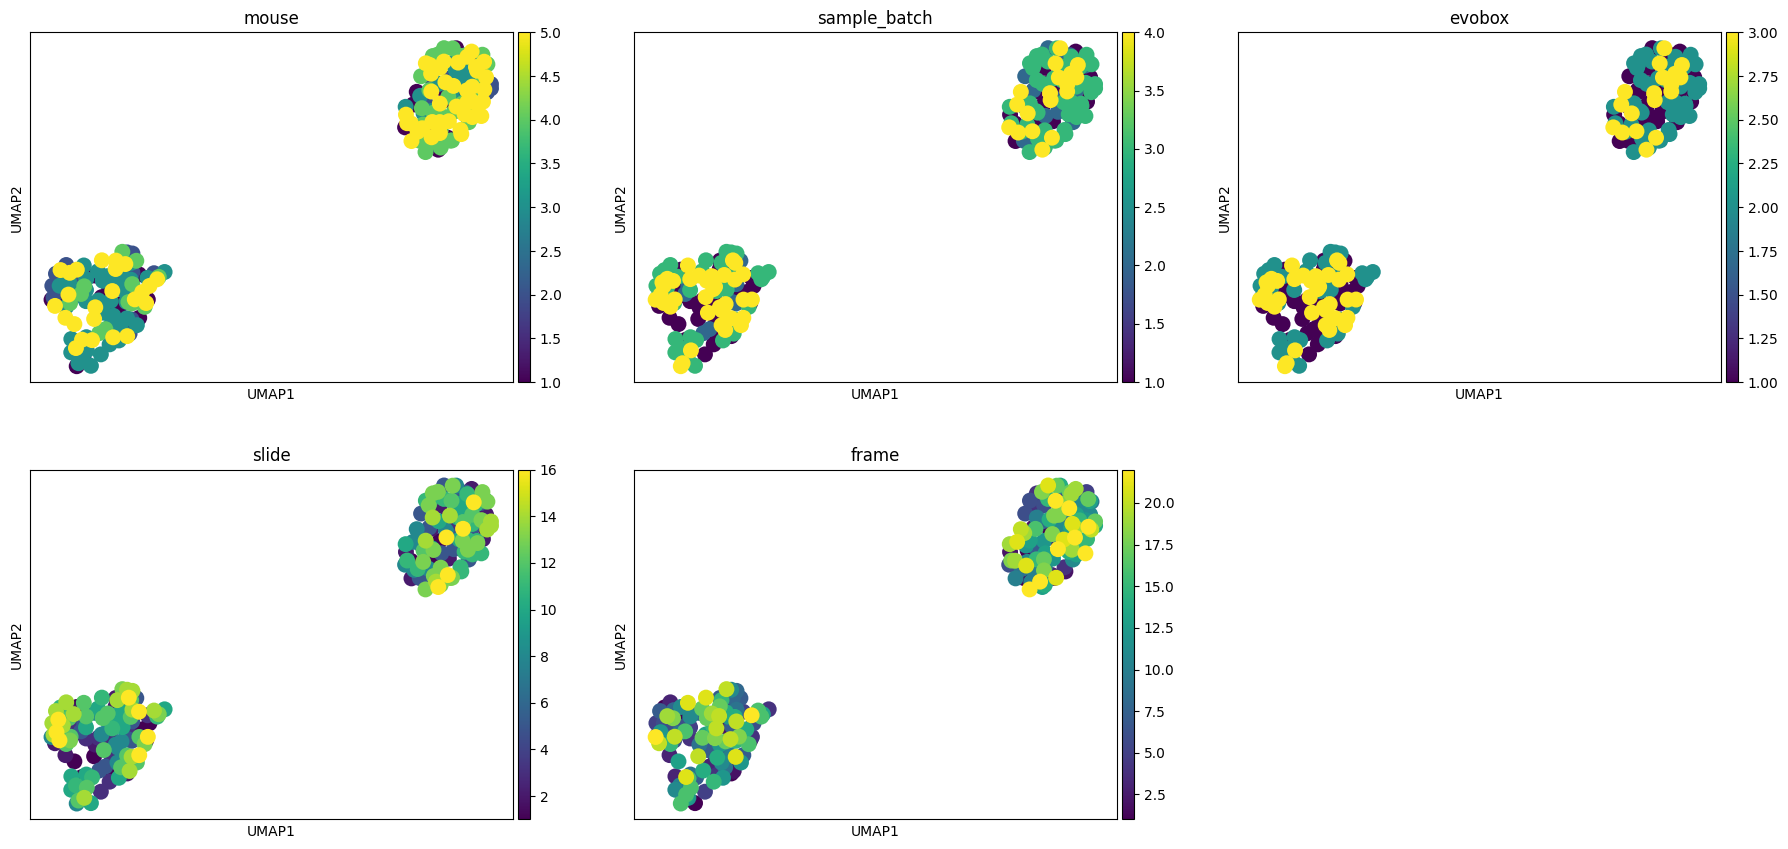

In [17]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["mouse", "sample_batch", "evobox", "slide", "frame"], 
    vmin="p01", vmax="p99",
    ncols=3,
)

## protDP

Let's also train [protDP](https://mengbo-li.github.io/protDP/index.html) for later comparison.

### Training

First, we'll fit protDP to the data.

In [18]:
%%capture
import anndata2ri
anndata2ri.activate()

import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [19]:
r_adata = scp.utils.prepare_anndata_for_R(adata)

In [20]:
%%R -i r_adata
library(protDP)

X <- assay(r_adata, "raw")
dpcfit <- dpc(X)

In [21]:
protdp_result = robjects.r("dpcfit")

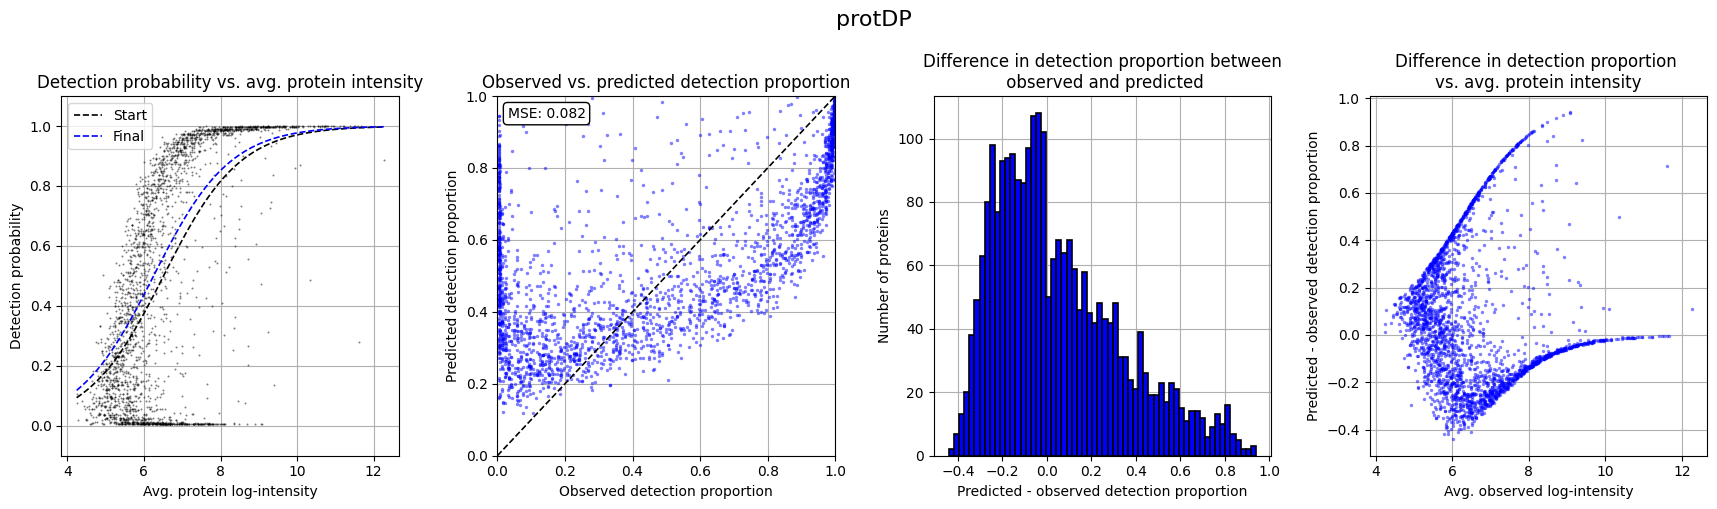

In [22]:
pl.plot_protein_detection_probability_panel_protDP(x_data, protdp_result)

### protDP vs PROTVI

Let's compare the results of the two methods:

/tmp/ipykernel_182368/1935104467.py:8: RuntimeWarning: Mean of empty slice
  x_est_miss_protein = np.nanmean(x_est_miss, axis=0)


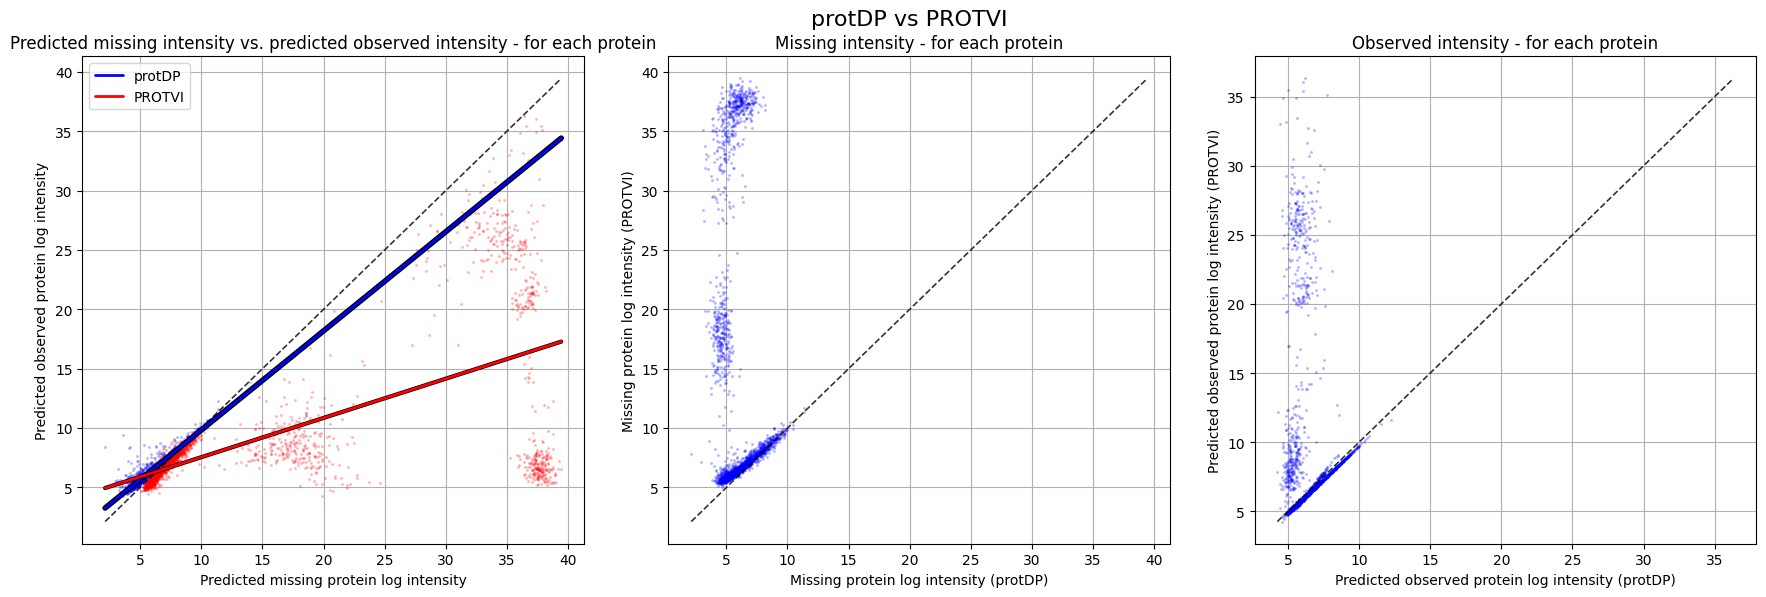

In [23]:
x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

x_est_obs_protein = np.nanmean(x_est_obs, axis=0)
x_est_miss_protein = np.nanmean(x_est_miss, axis=0)

pl.plot_model_intensity_comparison(
    x_data, 
    protdp_result["mu_obs"], 
    protdp_result["mu_mis"],
    x_est_obs_protein, 
    x_est_miss_protein,
    "protDP",
    "PROTVI"
)